In [2]:
import numpy as np
import os, sys, glob
import matplotlib.pyplot as plt
import open3d as o3d
from scipy.stats import chisquare
import pandas as pd

basedir = os.path.dirname(os.getcwd())
_py = os.path.join(basedir, 'py')
_data = os.path.join(basedir, 'data')
_images = os.path.join(basedir, 'images')

sys.path.insert(1, _py)
import lad
import figures

from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


INFO - 2021-09-10 10:07:58,497 - utils - NumExpr defaulting to 4 threads.


In [2]:
# define the path of the data stored
mockname = 'single'
datapath = os.path.join(_data, mockname)

# read the numpy files
for file in glob.glob(os.path.join(datapath, 'toy*.numpy')):
    df = np.loadtxt(file)
    filename = file.split('/')[-1].split('.')[0]

    outfile = os.path.join(_data, mockname, filename)
    np.save(outfile, df)

In [6]:
# define the path of the data stored
mockname = 'single'
datapath = os.path.join(_data, mockname, 'toy_trees')
file = glob.glob(os.path.join(datapath, 'tree*.npy'))
print(file)
df = np.load(file[0])

['/home/omar/myproj/planttech/data/single/toy_trees/tree_0.npy']


In [9]:
df[::10].shape

(120241, 16)

In [4]:
# define the path of the data stored
mockname = 'single'
datapath = os.path.join(_data, mockname)

# read the numpy files
files = {}
for file in glob.glob(os.path.join(datapath, 'toy*.npy')):
    df = np.load(file)
    filename = file.split('/')[-1]
    if df.shape[0] > 0:
        files[filename] = df
        print(filename, df.shape)
    else:
        print('file %s empty' %(filename))
    
# concatenate all data
df = np.concatenate(list(files.values()))
df.shape

toy300000.npy (360000, 16)
toy700000.npy (360000, 16)
toy800000.npy (360000, 16)
toy200000.npy (360000, 16)
toy600000.npy (360000, 16)
toy400000.npy (360000, 16)
toy100000.npy (360000, 16)
toy500000.npy (360000, 16)


(2880000, 16)

In [5]:
# pass this to a pandas data frame for simplicity
scan = pd.DataFrame(df, columns=['timestamp', 'yaw', 'pitch', 'distance','distance_noise',
                                'x','y','z',
                                'x_noise','y_noise','z_noise',
                                'object_id', 'color0', 'color1','color2', 'idx'])

scan

,timestamp,yaw,pitch,distance,distance_noise,x,y,z,x_noise,y_noise,z_noise,object_id,color0,color1,color2,idx
0,0.0,2.792527,-0.349066,19.475212,19.473883,6.302485,0.184492,-4.768372e-07,6.302054,0.185163,0.000956,1.851878e+09,204.0,204.0,204.0,0.0
1,0.0,2.792527,-0.347994,19.488605,19.483915,6.309018,0.159097,-2.384186e-06,6.307500,0.161465,0.003367,1.851878e+09,204.0,204.0,204.0,1.0
2,0.0,2.792527,-0.346922,19.502045,19.503557,6.315565,0.133648,-1.907349e-06,6.316054,0.132884,-0.001087,1.851878e+09,204.0,204.0,204.0,2.0
3,0.0,2.792527,-0.345848,19.515530,19.516897,6.322124,0.108150,0.000000e+00,6.322566,0.107457,-0.000980,1.851878e+09,204.0,204.0,204.0,3.0
4,0.0,2.792527,-0.344774,19.529070,19.524522,6.328699,0.082594,-1.430511e-06,6.327225,0.084903,0.003257,1.851878e+09,204.0,204.0,204.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2879995,0.0,3.489587,0.343699,23.814966,23.816835,2.596897,14.999995,7.414147e+00,2.596826,15.001906,7.413630,1.851878e+09,204.0,204.0,204.0,359995.0
2879996,0.0,3.489587,0.344774,23.806133,23.811354,2.591010,15.000000,7.436613e+00,2.590809,15.005339,7.435174,1.851878e+09,204.0,204.0,204.0,359996.0
2879997,0.0,3.489587,0.345848,23.797331,23.794697,2.585132,14.999997,7.459049e+00,2.585234,14.997303,7.459772,1.851878e+09,204.0,204.0,204.0,359997.0
2879998,0.0,3.489587,0.346922,23.788570,23.784597,2.579261,15.000000,7.481451e+00,2.579416,14.995934,7.482540,1.851878e+09,204.0,204.0,204.0,359998.0


In [6]:
### get the leaves only
leaves = scan['object_id'] == 1986094444.0
points = np.vstack((np.array(scan['x']), np.array(scan['y']), np.array(scan['z']))).transpose()
# pcd = lad.points2pcd(points)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points[leaves])
pcd.colors = o3d.utility.Vector3dVector(np.random.uniform(0, 1, size=np.asarray(pcd.points).shape))
o3d.visualization.draw_geometries([pcd])

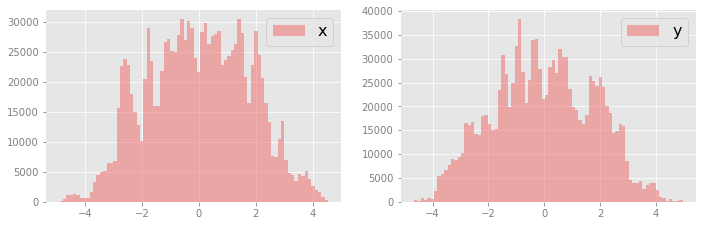

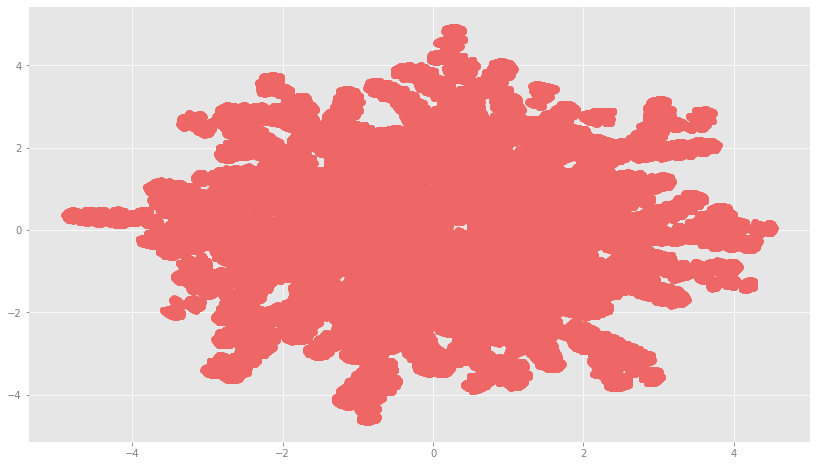

In [7]:
# Here we show how some of the point cloud parameters looks like.
cols = ['x','y']

plt.figure(figsize=(18, 4*3))

for num, i in enumerate(cols):
    
    plt.subplot(3,3,num+1)
    plt.hist(scan[i][leaves], 80, alpha=0.5, label=i)
    plt.legend()
    
plt.show()

plt.figure(figsize=(14, 8))
plt.scatter(scan['x'][leaves], scan['y'][leaves])

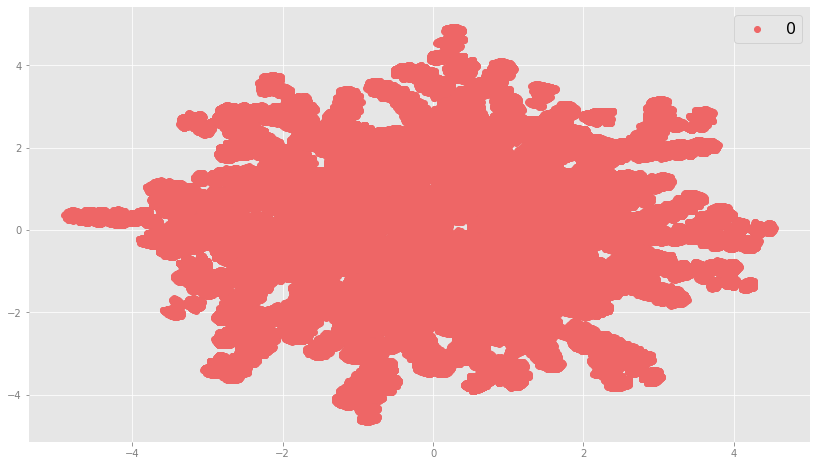

In [9]:
#
plt.figure(figsize=(14, 8))

# x = np.linspace(0, 16, 3)
# y = np.array([0, 8])

x, y = [0], [0]

trees = {}
num = 0
# dx, dy = 4, 4
dx, dy = 5, 5

resdir_name = 'toy_trees'
resdir = os.path.join(datapath, resdir_name)
if not os.path.exists(resdir):
    os.makedirs(resdir)

for i in x:
    for j in y:
        
        keep = np.ones(len(scan['x']), dtype=bool)
        keep &= (scan['x'] < i+dx) & (scan['x'] > i-dx)
        keep &= (scan['y'] < j+dy) & (scan['y'] > j-dy)
        
        plt.scatter(scan['x'][leaves & keep], scan['y'][leaves & keep], label=num)
        
        np.save(os.path.join(resdir, 'tree_%s' %(str(num))), scan[leaves & keep])
        
        num += 1
        
plt.legend()   

In [10]:
# get true leag-angle-distribution
file = "../data/single/mesh.ply"
mesh = o3d.io.read_triangle_mesh(file)
# 
mesh.compute_triangle_normals()
mesh.compute_vertex_normals()
# print(mesh.cluster_connected_triangles())
# print("Computing normal and rendering it.")
# 
print(np.asarray(mesh.triangle_normals))
print(np.asarray(mesh.triangles))
o3d.visualization.draw_geometries([mesh], mesh_show_wireframe=True)


[[0.37349295 0.25693007 0.89134166]
 [0.3734951  0.25692643 0.89134181]
 [0.37349183 0.25692803 0.89134272]
 ...
 [0.87693035 0.28342595 0.38815318]
 [0.87693022 0.28342695 0.38815275]
 [0.87693417 0.28341742 0.38815077]]
[[    0     1     2]
 [    0     2     3]
 [    0     3     4]
 ...
 [41138 41140 41141]
 [41142 41143 41144]
 [41142 41144 41145]]


In [6]:
# get leaf area
file = "../data/spherical_02/mesh.ply"
mesh = o3d.io.read_triangle_mesh(file)
cidx, nt, area = mesh.cluster_connected_triangles()
la = np.array(area)[np.array(nt) == 4][0]
np.round(la, 4)

0.0267

In [17]:
len(area)

7144

In [11]:
set(np.round(np.array(area), 5))

{0.01333, 0.02667}

In [21]:
np.array(area)[np.array(nt) == 4][0]

0.026666766174740775